[-0.1499516   0.00662721 -0.09906296 -0.07295471]
[  1.54991687 144.00241219 148.91381116  35.64261055]
[-0.03576975  0.01606535 -0.00685863 -0.03413539]
[-0.36398143 -0.0054132   0.02249878 -0.04301048]


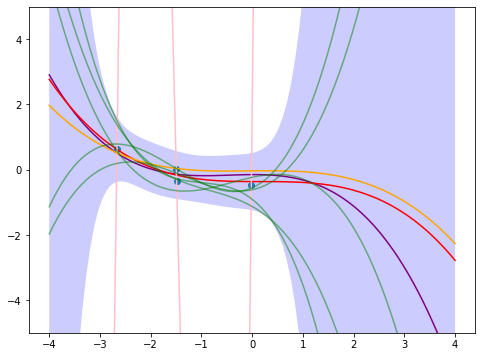

In [11]:
%matplotlib inline
 
import numpy as np
import matplotlib.pyplot as plt

# dataNum must be larger than dimension for Maximum Likelihood Estimation
# No error check is not performed in this script!!
dimension = 3
dataNum = 4
originalSigmaW2 = 0.01
minX = -4.0
maxX = 4.0
dataSigma2 = 0.25
sampleFunctionNum = 5
constSigma = 2.0 # +/- 2 sigma

# Constants for learning
priorSigmaW2 = 1.0
sigmaY2 = dataSigma2

# Constant for MAP estimation
#constLambda = 1.0
#constLambda = 5.0
constLambda = 20.0

def getPhi(X, dimension):
    phi = [1]
    for i in range(dimension):
        phi.append(phi[-1] * X)
    
    return phi

def getPhiArray(X, dimension):
    phiArray = []
    
    for x in X:
        phiArray.append(getPhi(x, dimension))

    return phiArray
        
def polynominalFunc(X, dimension, weight):
    retValue = []
    
    for x in X:
        phi = getPhi(x, dimension)
        
        retValue.append(weight.dot(phi))
        
    return retValue
    
trainX = []
trainY = []

meanOfWeight = np.zeros(dimension + 1)
covOfWeight = originalSigmaW2 * np.eye(dimension + 1)
weightForTrainingData = np.random.multivariate_normal(meanOfWeight, covOfWeight)

originalFuncX = np.linspace( minX, maxX, 100)
originalFuncY = polynominalFunc(originalFuncX, dimension, np.array(weightForTrainingData))

trainX = (maxX - minX) * np.random.rand(dataNum) + minX
trainY = np.random.normal(polynominalFunc(trainX, dimension, np.array(weightForTrainingData)), dataSigma2)

phiArray = np.array(getPhiArray(trainX, dimension))

# (3.72)
sigmaHat = np.linalg.inv((1/sigmaY2) * phiArray.T.dot(phiArray) + (1/priorSigmaW2) * np.eye(dimension + 1))
# (3.73)
muHat = (1/sigmaY2) * sigmaHat.dot(phiArray.T).dot(trainY.T)

sampledWeights = np.random.multivariate_normal(muHat, sigmaHat, size = sampleFunctionNum)
sampledFunctionYs = []
for w in sampledWeights:
    sampledFunctionYs.append(polynominalFunc(originalFuncX, dimension, w))

# (3.76)
predictedY = polynominalFunc(originalFuncX, dimension, muHat)

# (3.77)
predictedSigma = []
for x in originalFuncX:
    phiX = np.array(getPhi(x, dimension))
    predictedSigma.append(sigmaY2 + phiX.dot(sigmaHat).dot(phiX.T))
upperPredictedY = predictedY + constSigma * np.array(predictedSigma)
lowerPredictedY = predictedY - constSigma * np.array(predictedSigma)

# Maximum Likelihood estimation
# As shown in 3.4.1 (P.77), the weight is get with (2.7)
weightForMaxLikelihood = np.linalg.inv(phiArray.T.dot(phiArray)).dot(phiArray.T).dot(trainY.T)

# The determinant of phiArray.T.dot(phiArray) must not be zero,
# or its inverse matrix can not be calcurated
# This is why dataNum must be larger than dimension.
#print(phiArray.T.dot(phiArray))
#print(np.linalg.det(phiArray.T.dot(phiArray)))

# Get the predicted Ys with the weight
predictedYForMaxLikelihood = polynominalFunc(originalFuncX, dimension, weightForMaxLikelihood)

# MAP estimation with gaussian distribution as its prior distribution
# As show in page 78, the weight is calcurated by (2.15)
weightForMAP = np.linalg.inv(phiArray.T.dot(phiArray) + constLambda * np.eye(dimension + 1)).dot(phiArray.T).dot(trainY.T)
# Get the predicted Ys with the weight
predictedYForMAP = polynominalFunc(originalFuncX, dimension, weightForMAP)

print(weightForTrainingData)
print(weightForMaxLikelihood)
print(weightForMAP)
# Weight with Bayesian inference
print(muHat)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
plt.plot(originalFuncX, originalFuncY, color = "purple")
plt.plot(originalFuncX, predictedY, color = "red")
plt.plot(originalFuncX, predictedYForMaxLikelihood, color = "pink")
plt.plot(originalFuncX, predictedYForMAP, color = "orange")
for y in sampledFunctionYs:
    plt.plot(originalFuncX, y, color = "green", alpha = 0.5)
ax.fill_between(originalFuncX, upperPredictedY, lowerPredictedY, facecolor='blue', alpha=0.2)
plt.scatter(trainX, trainY)
ax.set_ylim(-5, 5)
plt.show()